# climate indices: reading pre-existing indices and creating indices from climate fields 

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

In [7]:
from datetime import datetime, timedelta
from dateutil.parser import parse as dparse
import calendar

## NINO3.4

In [46]:
url = 'https://www.esrl.noaa.gov/psd/data/correlation/nina34.data'

In [47]:
nino_esrl = pd.read_table(url, skiprows=1, skipfooter=3, engine='python', sep=r'\s+', header=None, na_values=[-99.99], index_col=0)

In [4]:
nino_esrl.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950,24.55,25.06,25.87,26.28,26.18,26.46,26.29,25.88,25.74,25.69,25.47,25.29
1951,25.24,25.71,26.90,27.58,27.92,27.73,27.60,27.02,27.23,27.20,27.25,26.91
1952,26.67,26.74,27.17,27.80,27.79,27.18,26.53,26.30,26.36,26.26,25.92,26.21


In [48]:
nino_esrl = nino_esrl.stack(dropna=False)

In [49]:
date_start = datetime(*list(nino_esrl.index[0]) + [1])

In [50]:
date_end = datetime(*list(nino_esrl.index[-1]) + [1])

In [51]:
nino_esrl.index = pd.date_range(start=date_start, end=date_end, freq='MS')

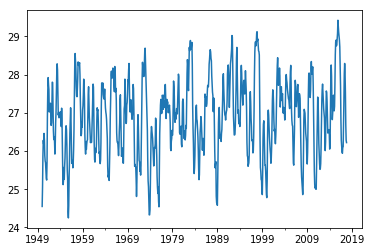

In [52]:
nino_esrl.plot()

In [55]:
nino_esrl = nino_esrl.to_frame(name='NINO34')

In [56]:
clim_esrl = nino_esrl.loc['1981':'2010',:]

In [57]:
clim_esrl = clim_esrl.groupby(clim_esrl.index.month).mean()

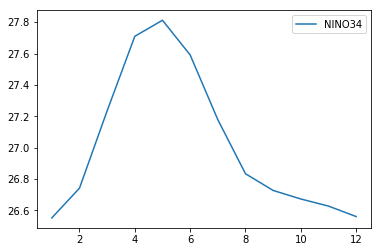

In [58]:
clim_esrl.plot()

In [59]:
def demean(x): 
    return x - x.loc['1981':'2010',:].mean()

In [61]:
nino_esrl = nino_esrl.groupby(nino_esrl.index.month).apply(demean)

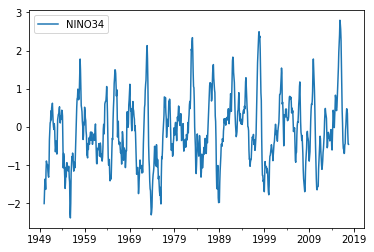

In [62]:
nino_esrl.plot()

In [35]:
nino_cpc = pd.read_table('http://www.cpc.ncep.noaa.gov/data/indices/ersst5.nino.mth.81-10.ascii', sep=r'\s+')

In [36]:
nino_cpc.tail()

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
809,2017,6,22.89,-0.12,26.67,0.17,29.28,0.49,28.05,0.46
810,2017,7,21.65,-0.28,25.84,0.15,29.15,0.42,27.53,0.35
811,2017,8,20.68,-0.33,24.86,-0.24,28.86,0.22,26.69,-0.14
812,2017,9,19.93,-0.80,24.17,-0.76,28.72,0.06,26.28,-0.45
813,2017,10,20.20,-0.85,24.30,-0.65,28.62,-0.02,26.22,-0.45


In [37]:
nino_cpc = nino_cpc.loc[:,['YR','MON','ANOM.3']]

In [38]:
nino_cpc.columns = ['year','month','nino34']

In [39]:
nino_cpc.loc[:,'day'] = 1

In [40]:
index = pd.to_datetime(nino_cpc.loc[:,['year','month','day']])

In [41]:
nino_cpc.index = index

In [42]:
nino_cpc.head()

,year,month,nino34,day
1950-01-01,1950,1,-2.00,1
1950-02-01,1950,2,-1.68,1
1950-03-01,1950,3,-1.37,1
1950-04-01,1950,4,-1.43,1
1950-05-01,1950,5,-1.63,1


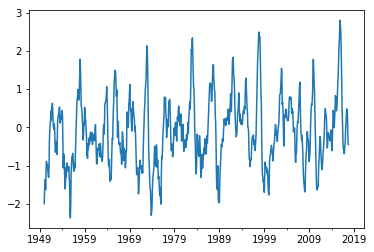

In [43]:
nino_cpc.nino34.plot()

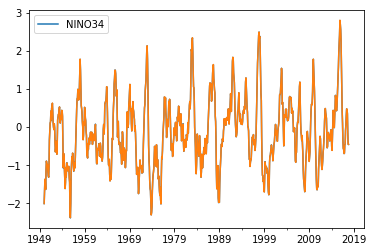

In [65]:
f, ax = plt.subplots()
nino_esrl.plot(ax=ax)
nino_cpc.nino34.plot(ax=ax)


In [66]:
nino_cpc_r3 = nino_cpc.rolling(window=3, min_periods=3).mean()

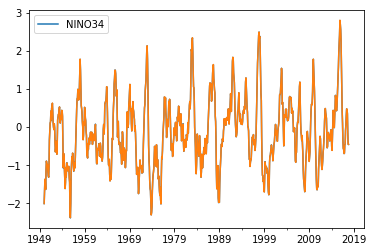

In [67]:
f, ax = plt.subplots()
nino_esrl.plot(ax=ax)
nino_cpc.nino34.plot(ax=ax)

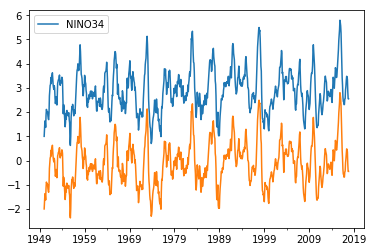

In [69]:
f, ax = plt.subplots()
(nino_esrl + 3).plot(ax=ax)
nino_cpc.nino34.plot(ax=ax)

## make your own indice from a climate field 

### download the ERSST V5 data using the [requests](http://docs.python-requests.org/en/master/) library

In [98]:
url = "https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/netcdf/"

In [99]:
for date in pd.date_range(start='1979-1-1', end='2017-10-1', freq='MS'):
    filename = "ersst.v5.{:%Y%m}.nc".format(date)
    r = requests.get(url + filename)
    with open('../data/{}'.format(filename),'wb') as f:
        f.write(r.content)
    dset = xr.open_dataset('../data/{}'.format(filename))
    dset = dset.sel(lat=slice(-40, 40), lon=slice(100,300))
    os.remove('../data/{}'.format(filename))
    dset.to_netcdf('../data/{}'.format(filename))
    dset.close()

In [100]:
from glob import glob

In [101]:
dset = xr.open_mfdataset(glob('../data/*.nc'))

In [105]:
dset

<xarray.Dataset>
Dimensions:  (lat: 41, lon: 130, time: 466)
Coordinates:
  * lat      (lat) float64 -40.0 -38.0 -36.0 -34.0 -32.0 -30.0 -28.0 -26.0 ...
  * lon      (lon) float64 100.0 102.0 104.0 106.0 108.0 110.0 112.0 114.0 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    sst      (time, lat, lon) float64 dask.array<shape=(466, 41, 130), chunksize=(1, 41, 130)>
    ssta     (time, lat, lon) float64 dask.array<shape=(466, 41, 130), chunksize=(1, 41, 130)>
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.197901
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    institution:                NOAA/NESDIS/NCEI/CCOG
    creator_name:               Boyin Huang
    creator_email:             

In [104]:
dset = dset.squeeze(drop=True)

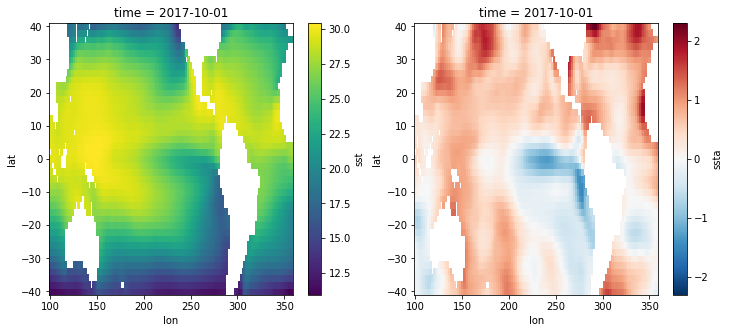

In [111]:
f, axes = plt.subplots(ncols=2, figsize=(12,5))
dset.sel(time='2017-10-01')['sst'].plot(ax=axes[0])
dset.sel(time='2017-10-01')['ssta'].plot(ax=axes[1])

![](./images/oceanic-indices-map.gif)

+ Nino 1 : Latitude 0° to 5° S & Longitude 80° W to 90° W  
+ Nino 2 : Latitude 5° S to 10° S & Longitude 80° W to 90° W  
+ Nino 3 : Latitude 5°N to 5° S & Longitude 90° W to 150° W  
+ Nino 3.4 : Latitude 5° N to 5° S & Longitude 120° W to 170° W  
+ Nino 4 : Latitude 5°N to 5° S & Longitude 160° E to 150° W  

In [114]:
nino34 = {'latS': -5, 'latN': 5, 'lonW': 170, 'lonE': 120}

In [116]:
360-170

190

In [117]:
nino = dset.sel(lat=slice(nino34['latS'], nino34['latN']), lon=slice(360 - nino34['lonW'], 360 - nino34['lonE']))

In [119]:
nino_indice = nino.mean('lat').mean('lon')

In [121]:
nino_indice.load()

<xarray.Dataset>
Dimensions:  (time: 466)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    sst      (time) float64 26.42 26.54 27.28 27.84 27.69 27.43 26.83 26.75 ...
    ssta     (time) float64 -0.1812 -0.2488 0.01697 0.146 -0.1237 -0.1282 ...

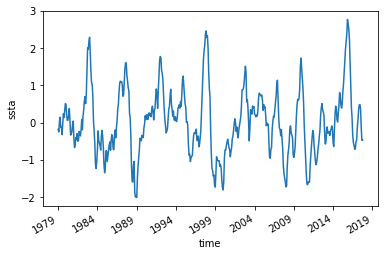

In [122]:
nino_indice['ssta'].plot()

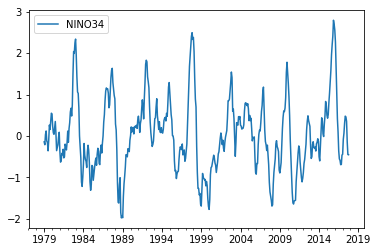

In [125]:
nino_esrl.loc['1979':,:].plot()

In [127]:
nino_indice_df = nino_indice.to_dataframe()

In [129]:
nino_indice_df.tail()

,sst,ssta
time,,
2017-06-01,28.045594,0.483936
2017-07-01,27.529682,0.379875
2017-08-01,26.689923,-0.123088
2017-09-01,26.279665,-0.475981
2017-10-01,26.223660,-0.471415
